Saving content.jpg to content (4).jpg
Saving style.jpg to style (4).jpg
Step 0, Total loss: 22185007644672.0
Step 50, Total loss: 2163830554624.0
Step 100, Total loss: 1305499009024.0
Step 150, Total loss: 886623567872.0
Step 200, Total loss: 577239908352.0
Step 250, Total loss: 359298564096.0


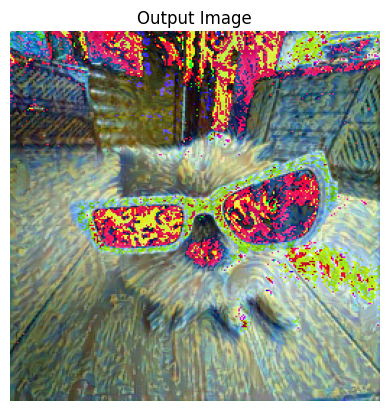

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install required libraries
!pip install torch torchvision

# 📌 Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# 📌 Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Function to load image
def load_image(img_path, max_size=256):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),
        transforms.ToTensor()
    ])
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# 📌 Upload content and style images
from google.colab import files
uploaded = files.upload()

# 📌 Load images
content = load_image("content.jpg")
style = load_image("style.jpg")

# 📌 Load pre-trained VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# 📌 Clone the content image for target
target = content.clone().requires_grad_(True)

# 📌 Select layers to extract features
style_layers = ['0', '5', '10', '19', '28']
content_layers = ['21']

# 📌 Helper functions
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# 📌 Extract features
content_features = get_features(content, vgg, content_layers)
style_features = get_features(style, vgg, style_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

# 📌 Define weights
style_weight = 1e6
content_weight = 1

# 📌 Optimizer
optimizer = optim.Adam([target], lr=0.003)

# 📌 Style transfer training
steps = 300
for step in range(steps):
    target_features = get_features(target, vgg, style_layers + content_layers)

    # Compute content loss
    content_loss = torch.mean((target_features['21'] - content_features['21'])**2)

    # Compute style loss
    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((target_gram - style_gram)**2)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)  # ✅ Fixed error here
    optimizer.step()

    # Print update
    if step % 50 == 0:
        print(f"Step {step}, Total loss: {total_loss.item()}")

# 📌 Save and display output image
final_img = target.cpu().clone().squeeze(0)
final_img = transforms.ToPILImage()(final_img)
final_img.save("output.jpg")
plt.imshow(final_img)
plt.title("Output Image")
plt.axis("off")
plt.show()

# 📌 Download the output image
from google.colab import files
files.download("output.jpg")
